# Overview

The article chosen by me is about fine-tuning a T5 model for the task of definition generation.

I will do fine-tuning for the same task for the Russian language using FRED-T5-1.7B.

The dataset I will use is my own Wiktionary dataset I use in my diploma.

Use accelerator if you want to check if this works and set DEBUG_MODE to True. It should take around 15 minutes for the pipeline to finish if DEBUG_MODE is used.

The dataset used: https://kaggle.com/datasets/a6684798b8a2975ae512e3402de6739421d3dc339d1a1a4e53b423264e9f05a8

In [ ]:
DEBUG_MODE = False # Set it to false when you really want to train it all the way instead of just checking if it works or not
MODEL_TYPE = "1.7B" # Either "1.7B" or "large" (700 million parameters)

!pip install transformers
!pip install datasets
!pip install peft
!pip install matplotlib

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    BatchEncoding,
    DataCollatorForSeq2Seq,
    PreTrainedTokenizer,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    TrainerCallback,
    TrainerControl,
    TrainerState,
    TrainingArguments
)
from datasets import Dataset, DatasetDict
import torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 5.0 MB/s eta 0:00:00a 0:00:01


2024-03-13 16:09:49.546525: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 16:09:49.546640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 16:09:49.681702: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import random
import os

def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(42)

# Dataset

In [ ]:
def load_dataset_split(directory: str | Path, debug_mode: bool = False) -> DatasetDict:
    """
    Load the train, test and validation splits of the dataset.

    :param directory: The directory containing the splits.
    :param debug_mode: If True, only load a small subset of the data.
    :return: The splits.
    """
    directory_path = Path(directory)

    train_df = pd.read_json(directory_path / "train.jsonl", lines=True)
    train_df = train_df.iloc[::-1].reset_index(drop=True)
    test_df = pd.read_json(directory_path / "test.jsonl", lines=True)
    val_df = pd.read_json(directory_path / "val.jsonl", lines=True)

    if debug_mode:
        train_df = train_df.head(2000)
        test_df = test_df.head(300)
        val_df = val_df.head(300)

    return DatasetDict({
        "train": Dataset.from_pandas(train_df),
        "test": Dataset.from_pandas(test_df),
        "val": Dataset.from_pandas(val_df)
    })

In [ ]:
dataset_dict = load_dataset_split("/kaggle/input/23-dec-wiktionary/cleaned_splits")

In [ ]:
def inspect_data(dataset_dict):
    for split in dataset_dict:
        print(f"---{split.upper()} SPLIT---")
        print(dataset_dict[split])
        print(f"Number of entries: {len(dataset_dict[split])}")
        print(dataset_dict[split].to_pandas().head(n=20))
        print("\n")

inspect_data(dataset_dict)

---TRAIN SPLIT---
Dataset({
    features: ['input_text', 'target_text'],
    num_rows: 167035
})
Number of entries: 167035
                                           input_text  \
0   <LM>Контекст: "Моего друга зовут Джанджаку." О...   
1   <LM>Контекст: "Шечка — одна из многочисленных ...   
2   <LM>Контекст: "Мою подругу зовут Сия." Определ...   
3   <LM>Контекст: "Из-за трухлявой спины я никогда...   
4   <LM>Контекст: "Моего друга зовут Баламут." Опр...   
5   <LM>Контекст: "Бэггеры являются одной из субку...   
6   <LM>Контекст: "Там, где не растёт красный мак,...   
7   <LM>Контекст: "Мою подругу зовут Хицкур." Опре...   
8   <LM>Контекст: "В случае с трансгендерностью, «...   
9   <LM>Контекст: "Грузинский парламент отказался ...   
10  <LM>Контекст: "Эфир расщепился." Определение с...   
11  <LM>Контекст: "Моего друга зовут Нуцал." Опред...   
12  <LM>Контекст: "Первые попытки объяснить происх...   
13  <LM>Контекст: "Всё бы это ещё, пожалуй, было п...   
14  <LM>Контекст: "Хар

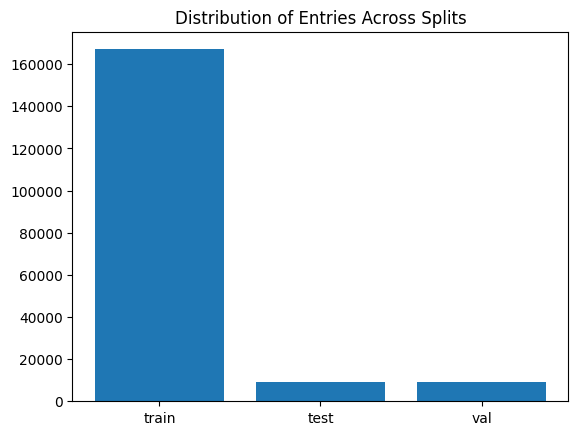

In [ ]:
def plot_split_distribution(dataset_dict):
    split_sizes = {split: len(dataset_dict[split]) for split in dataset_dict}
    plt.bar(split_sizes.keys(), split_sizes.values())
    plt.title("Distribution of Entries Across Splits")
    plt.show()

plot_split_distribution(dataset_dict)

In [ ]:
def check_duplicates(dataset_dict):
    for split in dataset_dict:
        df = dataset_dict[split].to_pandas()
        duplicate_count = df.duplicated(subset=['input_text']).sum()
        print(f"Number of duplicates in {split}: {duplicate_count}")

check_duplicates(dataset_dict)

Number of duplicates in train: 85
Number of duplicates in test: 0
Number of duplicates in val: 0


In [ ]:
!pip install razdel
!pip install seaborn

100%|██████████| 167035/167035 [00:59<00:00, 2798.24it/s]
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
100%|██████████| 9280/9280 [00:03<00:00, 2786.59it/s]
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
100%|██████████| 9280/9280 [00:03<00:00, 2823.73it/s]
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


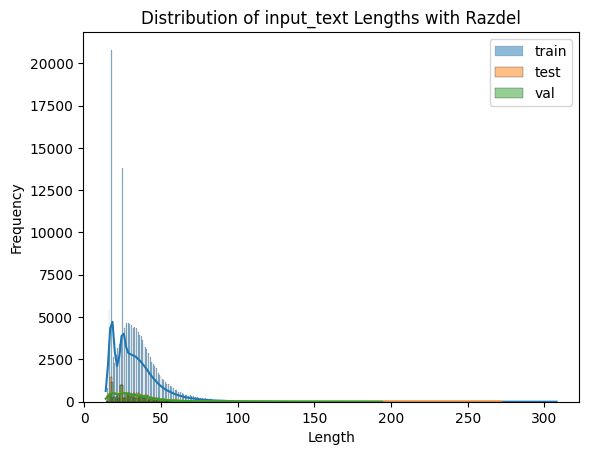

100%|██████████| 167035/167035 [00:13<00:00, 11959.66it/s]
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
100%|██████████| 9280/9280 [00:00<00:00, 11874.77it/s]
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
100%|██████████| 9280/9280 [00:00<00:00, 12070.61it/s]
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


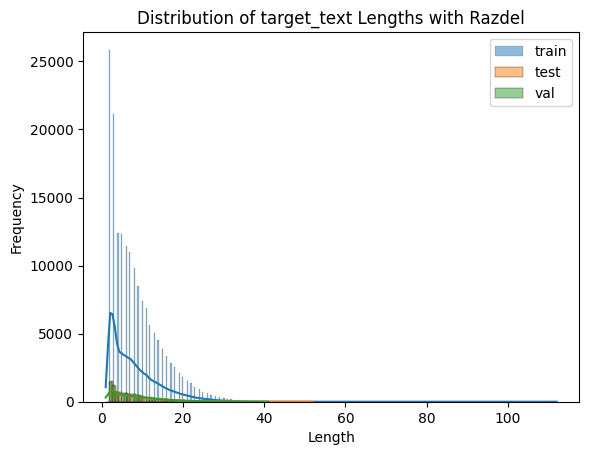

In [ ]:
from razdel import tokenize
import seaborn as sns
from collections import Counter
from tqdm import tqdm
tqdm.pandas()

def tokenize_razdel(text):
    tokens = [token.text for token in tokenize(text)]
    return tokens

def plot_text_length_razdel(dataset_dict, text_column):
    lengths = []
    for split in dataset_dict:
        df = dataset_dict[split].to_pandas()
        df[f'{text_column}_length'] = df[text_column].progress_apply(lambda x: len(tokenize_razdel(x)))
        lengths.extend(df[f'{text_column}_length'].tolist())

        sns.histplot(df[f'{text_column}_length'], kde=True, label=split)

    plt.legend()
    plt.title(f"Distribution of {text_column} Lengths with Razdel")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    plt.show()

    return lengths

input_text_lengths_razdel = plot_text_length_razdel(dataset_dict, "input_text")
target_text_lengths_razdel = plot_text_length_razdel(dataset_dict, "target_text")

## Conclusion

The dataset if mostly fine. The problems I will fix:
- Duplicates
- There are many examples for rivers and names. I will keep only a small part of them since they are basically the same. I suppose that only a small part of those will be enough for the model to learn how to detect rivers and names.
- Texts that are too long

PS: It would also make sense to check for empty rows, but 1) I have no time, 2) I made this dataset, so you can trust me that there are no empty rows

In [ ]:
dataset_dict = load_dataset_split("/kaggle/input/23-dec-wiktionary/cleaned_splits", debug_mode=True if DEBUG_MODE else False)

inspect_data(dataset_dict)

---TRAIN SPLIT---
Dataset({
    features: ['input_text', 'target_text'],
    num_rows: 167035
})
Number of entries: 167035
                                           input_text  \
0   <LM>Контекст: "Моего друга зовут Джанджаку." О...   
1   <LM>Контекст: "Шечка — одна из многочисленных ...   
2   <LM>Контекст: "Мою подругу зовут Сия." Определ...   
3   <LM>Контекст: "Из-за трухлявой спины я никогда...   
4   <LM>Контекст: "Моего друга зовут Баламут." Опр...   
5   <LM>Контекст: "Бэггеры являются одной из субку...   
6   <LM>Контекст: "Там, где не растёт красный мак,...   
7   <LM>Контекст: "Мою подругу зовут Хицкур." Опре...   
8   <LM>Контекст: "В случае с трансгендерностью, «...   
9   <LM>Контекст: "Грузинский парламент отказался ...   
10  <LM>Контекст: "Эфир расщепился." Определение с...   
11  <LM>Контекст: "Моего друга зовут Нуцал." Опред...   
12  <LM>Контекст: "Первые попытки объяснить происх...   
13  <LM>Контекст: "Всё бы это ещё, пожалуй, было п...   
14  <LM>Контекст: "Хар

In [ ]:
from datasets import Dataset

def remove_duplicates_from_dataset_dict(dataset_dict):
    """
    Remove duplicates from each split in the dataset_dict based on 'input_text'.

    :param dataset_dict: A DatasetDict object containing splits of the dataset.
    :return: A DatasetDict object with duplicates removed from each split.
    """
    cleaned_dataset_dict = {}
    for split in dataset_dict:
        df = dataset_dict[split].to_pandas()
        df_cleaned = df.drop_duplicates(subset=['input_text']).reset_index(drop=True)
        cleaned_dataset_dict[split] = Dataset.from_pandas(df_cleaned)

    return DatasetDict(cleaned_dataset_dict)

In [ ]:
dataset_dict = remove_duplicates_from_dataset_dict(dataset_dict)

check_duplicates(dataset_dict)

Number of duplicates in train: 0
Number of duplicates in test: 0
Number of duplicates in val: 0


In [ ]:
def remove_excess_target_word_rows(dataset_dict, target_word, n, target_column='target_text'):
    """
    Remove all but "n" amount of rows containing "target_word" in its target_column for each split in the dataset_dict.

    :param dataset_dict: A DatasetDict object containing splits of the dataset.
    :param target_word: The word to search for in the target_column.
    :param n: The number of rows to keep that contain the target_word.
    :param target_column: The name of the column to search for the target_word. Defaults to 'target_text'.
    :return: A DatasetDict object with excess rows removed.
    """
    cleaned_dataset_dict = {}
    for split in dataset_dict:
        df = dataset_dict[split].to_pandas()

        contains_target_word = df[target_column].str.contains(target_word)

        df_with_target_word = df[contains_target_word]
        df_without_target_word = df[~contains_target_word]

        df_with_target_word_reduced = df_with_target_word.groupby(target_column).head(n)

        df_cleaned = pd.concat([df_without_target_word, df_with_target_word_reduced]).reset_index(drop=True)

        cleaned_dataset_dict[split] = Dataset.from_pandas(df_cleaned)

    return DatasetDict(cleaned_dataset_dict)

In [ ]:
dataset_dict = remove_excess_target_word_rows(dataset_dict, "река", 10 if DEBUG_MODE else 100)
dataset_dict = remove_excess_target_word_rows(dataset_dict, "имя", 10 if DEBUG_MODE else 100)
dataset_dict = remove_excess_target_word_rows(dataset_dict, "фамилия", 10 if DEBUG_MODE else 100)

inspect_data(dataset_dict)

---TRAIN SPLIT---
Dataset({
    features: ['input_text', 'target_text'],
    num_rows: 138431
})
Number of entries: 138431
                                           input_text  \
0   <LM>Контекст: "Из-за трухлявой спины я никогда...   
1   <LM>Контекст: "Бэггеры являются одной из субку...   
2   <LM>Контекст: "Там, где не растёт красный мак,...   
3   <LM>Контекст: "В случае с трансгендерностью, «...   
4   <LM>Контекст: "Грузинский парламент отказался ...   
5   <LM>Контекст: "Эфир расщепился." Определение с...   
6   <LM>Контекст: "Первые попытки объяснить происх...   
7   <LM>Контекст: "Всё бы это ещё, пожалуй, было п...   
8   <LM>Контекст: "Харузин сообщает предание, связ...   
9   <LM>Контекст: "Философ, какого бы он ни был то...   
10  <LM>Контекст: "Дупликация гена, кодирующего че...   
11  <LM>Контекст: "Сколько яду в ваших словах!" Оп...   
12  <LM>Контекст: "Меняет тип ткани и её дальнейша...   
13  <LM>Контекст: "Каждый буддист, проезжая здесь,...   
14  <LM>Контекст: "Кле

In [ ]:
def remove_long_texts_by_column(dataset_dict, thresholds):
    """
    Remove rows based on different token length thresholds for specified columns after tokenization.

    :param dataset_dict: A DatasetDict object containing splits of the dataset.
    :param thresholds: A dictionary where each key is a column name and the value is the token length threshold.
    :return: A DatasetDict object with rows exceeding thresholds removed.
    """
    cleaned_dataset_dict = {}
    for split in dataset_dict:
        df = dataset_dict[split].to_pandas()

        for column, max_tokens in thresholds.items():
            df = df[df[column].apply(lambda text: len(tokenize_razdel(text)) <= max_tokens)].reset_index(drop=True)

        cleaned_dataset_dict[split] = Dataset.from_pandas(df)

    return DatasetDict(cleaned_dataset_dict)

In [ ]:
dataset_dict = remove_long_texts_by_column(dataset_dict, {"input_text": 80, "target_text": 20})

inspect_data(dataset_dict)

---TRAIN SPLIT---
Dataset({
    features: ['input_text', 'target_text'],
    num_rows: 127421
})
Number of entries: 127421
                                           input_text  \
0   <LM>Контекст: "Из-за трухлявой спины я никогда...   
1   <LM>Контекст: "Бэггеры являются одной из субку...   
2   <LM>Контекст: "Там, где не растёт красный мак,...   
3   <LM>Контекст: "В случае с трансгендерностью, «...   
4   <LM>Контекст: "Грузинский парламент отказался ...   
5   <LM>Контекст: "Эфир расщепился." Определение с...   
6   <LM>Контекст: "Всё бы это ещё, пожалуй, было п...   
7   <LM>Контекст: "Харузин сообщает предание, связ...   
8   <LM>Контекст: "Философ, какого бы он ни был то...   
9   <LM>Контекст: "Дупликация гена, кодирующего че...   
10  <LM>Контекст: "Сколько яду в ваших словах!" Оп...   
11  <LM>Контекст: "Меняет тип ткани и её дальнейша...   
12  <LM>Контекст: "Каждый буддист, проезжая здесь,...   
13  <LM>Контекст: "Мы сели в шикарной чайной комна...   
14  <LM>Контекст: "Оце

# Check metrics on the raw model

In [ ]:
from torch import dtype
from transformers import AutoTokenizer, T5ForConditionalGeneration
import json
from peft import PeftModel

In [ ]:
def get_current_torch_device() -> str:
    """
    Get the current torch device.

    :return: The current torch device.
    """
    if torch.cuda.is_available():
        return "cuda"

    if torch.backends.mps.is_available():
        return "mps"

    return "cpu"

In [ ]:
def load_model(model_checkpoint: str | Path, torch_dtype: dtype = torch.float32,
               lora_checkpoint: str | Path = "") -> tuple[T5ForConditionalGeneration, AutoTokenizer]:
    """
    Load a model from a checkpoint.

    :param model_checkpoint: The path to the checkpoint.
    :param torch_dtype: The precision in which to load the model.
    :param lora_checkpoint: The path to the LoRa checkpoint.
    :return: The model and the tokenizer.
    """
    model = T5ForConditionalGeneration.from_pretrained(model_checkpoint, torch_dtype=torch_dtype)
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

    if lora_checkpoint:
        model = PeftModel.from_pretrained(model, lora_checkpoint)
    model.to(get_current_torch_device())

    return model, tokenizer

In [ ]:
def run_inference(model: T5ForConditionalGeneration, tokenizer: AutoTokenizer,
                  input_texts: list[str], max_length: int = 100) -> list[str]:
    """
    Run batched inference.

    :param model: The model.
    :param tokenizer: The tokenizer.
    :param input_texts: The input texts.
    :param max_length: The maximum length of the output.
    :return: The generated texts.
    """
    inputs = tokenizer(input_texts, return_tensors="pt", padding=True).to(model.device)

    output_sequences = model.generate(
        input_ids=inputs.input_ids,
        eos_token_id=tokenizer.eos_token_id,
        early_stopping=True,
        max_length=max_length,
        num_beams=3
    ).cpu()

    outputs = np.where(output_sequences != -100, output_sequences, tokenizer.pad_token_id)

    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

In [ ]:
def run_inference_over_dataset(  # pylint: disable=too-many-arguments
        model: T5ForConditionalGeneration,
        tokenizer: AutoTokenizer,
        data: list[dict[str, str]],
        input_field: str,
        output_file_path: str | Path,
        max_length: int = 100,
        batch_size: int = 8) -> None:
    """
    Run batched inference over a dataset.

    :param model: The model.
    :param tokenizer: The tokenizer.
    :param data: The dataset.
    :param input_field: The name of the field in the dataset that contains the input text.
    :param output_file_path: The path to the output file.
    :param max_length: The maximum length of the output.
    :param batch_size: The size of the batch for batched inference.
    """
    entries_inferred = 0
    total_entries = len(data)

    for i in tqdm(range(0, total_entries, batch_size)):
        batch = data[i:i + batch_size]
        input_texts = [entry[input_field] for entry in batch]
        output_texts = run_inference(model, tokenizer, input_texts, max_length=max_length)

        for j, output_text in enumerate(output_texts):
            save_output(output_text, output_file_path, batch[j])

        entries_inferred += len(batch)

In [ ]:
def save_output(output_text: str, output_save_filepath: str | Path, initial_json: dict) -> None:
    """
    Append generated text to the output file.

    :param output_text: The generated text.
    :param output_save_filepath: The output file of JSON Lines format.
    :param initial_json: The initial JSON object.
    """
    with open(output_save_filepath, "a", encoding="utf-8") as output_save_file:
        initial_json["generated_text"] = output_text
        output_save_file.write(json.dumps(initial_json, ensure_ascii=False) + "\n")

In [ ]:
def load_dataset_for_inference(input_file_path: str | Path, input_field: str,
                               limit: int | None = None) -> list[dict[str, str]]:
    """
    Load the dataset for inference.

    :param input_file_path: The path to the input file.
    :param input_field: The name of the field in the dataset that contains the input text.
    :param limit: How many rows to load. Will load all if not passed.
    :return: The dataset.
    :raises ValueError: If the input field is not found in the JSON object.
    """
    data = []

    with open(input_file_path, "r", encoding="utf-8") as input_file:
        for line in input_file:
            json_object = json.loads(line)
            if input_field not in json_object:
                raise ValueError(f"Field {input_field} not found in JSON object.")
            data.append(json_object)

            if limit and len(data) == limit:
                break

    return data

In [ ]:
input_file_path = f"/kaggle/input/23-dec-wiktionary/cleaned_splits/test.jsonl"
output_file_path = f"preds_raw.jsonl"

data = load_dataset_for_inference(input_file_path, "input_text", limit=300)

model, tokenizer = load_model(f"ai-forever/FRED-T5-{MODEL_TYPE}", torch_dtype=torch.float32)

run_inference_over_dataset(model, tokenizer, data, "input_text", output_file_path)

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/6.96G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/20.2k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.50k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 38/38 [01:44<00:00,  2.76s/it]


In [ ]:
def load_target_pred_dataset(dataset_path: str | Path, target_field: str,
                             pred_field: str) -> tuple[list[str], list[str]]:
    """
    Load the target and predicted texts from a dataset.

    :param dataset_path: The path to the JSON Lines dataset.
    :param target_field: The name of the field containing the target texts.
    :param pred_field: The name of the field containing the predicted texts.
    :return: The target texts and the predicted texts.
    """
    with open(dataset_path, "r", encoding="utf-8") as dataset_file:
        dataset = [json.loads(line) for line in dataset_file if line.strip()]

    target_texts = [sample[target_field] for sample in dataset]
    pred_texts = [sample[pred_field] for sample in dataset]

    return target_texts, pred_texts

In [ ]:
!pip install evaluate
!pip install sacrebleu
!pip install rouge_score
!pip install bert_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 5.1 MB/s eta 0:00:00


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=1c1ee59b241bc7c315e6af791574c7f17f7973f451dce016ea773c528b8a4039
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
from evaluate import load
from razdel import tokenize as regex_tokenize


def get_bleu_score(predictions: list[str], labels: list[str]) -> float:
    """
    Compute the BLEU score for a list of predictions and labels.

    :param predictions: The list of predictions.
    :param labels: The list of labels.
    :return: The BLEU score.
    """
    blue_metric = load("sacrebleu")

    blue_results = blue_metric.compute(predictions=predictions,
                                       references=labels,
                                       tokenize="intl")
    return blue_results["score"]


def get_rouge_score(predictions: list[str], labels: list[str]) -> float:
    """
    Compute the ROUGE score for a list of predictions and labels.

    :param predictions: The list of predictions.
    :param labels: The list of labels.
    :return: The score for ROUGE-L.
    """
    rouge_metric = load("rouge")

    rouge_results = rouge_metric.compute(predictions=predictions,
                                         references=labels,
                                         use_stemmer=False,
                                         tokenizer=lambda x: [
                                             token.text.lower() for token in regex_tokenize(x)
                                         ])

    return rouge_results["rougeL"]


def get_bert_score(predictions: list[str], labels: list[str],
                   device: str = "cpu") -> float:
    """
    Compute the BERT score for a list of predictions and labels.

    :param predictions: The list of predictions.
    :param labels: The list of labels.
    :param device: The PyTorch device to use (e.g. "cuda", "mps" or "cpu")
    :return: The score F1.
    """
    bert_metric = load("bertscore")

    bert_results = bert_metric.compute(predictions=predictions,
                                       references=labels,
                                       lang="ru",
                                       device=device)

    return sum(bert_results["f1"]) / len(bert_results["f1"])

In [ ]:
def evaluate_model_with_validation_dataset(dataset_path: str | Path, target_field: str,
                                           pred_field: str) -> dict[str, float]:
    """
    Evaluate the model on a dataset.

    :param dataset_path: The path to the JSON Lines dataset.
    :param target_field: The name of the field containing the target texts.
    :param pred_field: The name of the field containing the predicted texts.
    :return: The scores.
    """
    target_texts, pred_texts = load_target_pred_dataset(dataset_path, target_field, pred_field)

    bleu_score = get_bleu_score(target_texts, pred_texts)
    rouge_score = get_rouge_score(target_texts, pred_texts)
    bert_score = get_bert_score(target_texts, pred_texts, get_current_torch_device())

    return {
        "bleu": bleu_score,
        "rougeL": rouge_score,
        "bert-f1": bert_score
    }

In [ ]:
scores = evaluate_model_with_validation_dataset("preds_raw.jsonl", "target_text",
                                                "generated_text")

print(scores)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

{'bleu': 0.8564100536381719, 'rougeL': 0.10269194577784987, 'bert-f1': 0.649014317591985}


# Train

In [ ]:
from peft import get_peft_model, LoraConfig, TaskType
from typing import Any

In [ ]:
def patch_lora(model: Any) -> None:
    """
    Patch the LoRa model to support gradient_checkpointing.

    :param model: The transformers model to be patched.
    """
    if hasattr(model, "enable_input_require_grads"):
        model.enable_input_require_grads()
    else:
        def make_inputs_require_grad(module, input, output):  # pylint: disable=redefined-builtin
            output.requires_grad_(True)

        model.get_input_embeddings().register_forward_hook(make_inputs_require_grad)

In [ ]:
def preprocess_function(examples: dict, tokenizer: PreTrainedTokenizer) -> BatchEncoding:
    """
    Preprocess the examples for the model using the tokenizer.

    :param examples: The readable examples to preprocess.
    :param tokenizer: A tokenizer that was used to train the model.
    :return: The tokenized examples.
    """
    max_input_length = 1024
    max_target_length = 128

    model_inputs = tokenizer(examples["input_text"], max_length=max_input_length, truncation=True)

    targets = [text + tokenizer.eos_token for text in examples["target_text"]]

    labels = tokenizer(text_target=targets,
                       max_length=max_target_length,
                       truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
def plot_training_and_test_loss(log_history: list[dict], output_path: str | Path,
                                plot_epochs: bool = True) -> None:
    """
    Plot the training and test loss using information from the log history.

    :param log_history: The log history from the trainer.
    :param output_path: The path to save the plot to.
    :param plot_epochs: Whether to plot epochs or steps on the x-axis.
    :raises ValueError: If the train losses and test losses have different lengths.
    """
    train_losses = []
    test_losses = []
    steps = []
    epochs = []

    for entry in log_history:
        if 'loss' in entry:
            train_losses.append(entry['loss'])
            steps.append(entry['step'])
            epochs.append(entry['epoch'])
        if 'eval_loss' in entry:
            test_losses.append(entry['eval_loss'])

    if len(train_losses) != len(test_losses):
        print(f"Train losses: {train_losses}, test losses: {test_losses}, "
              f"steps: {steps}, epochs: {epochs}")
        raise ValueError("Train losses and test losses have different lengths")

    plt.figure(figsize=(10, 5))

    if plot_epochs:
        plt.plot(epochs, train_losses, label='Training Loss', marker='o', linestyle='-',
                 color='b')
        plt.plot(epochs, test_losses, label='Test Loss', marker='o', linestyle='-', color='r')
        plt.title('Training and Test Loss Over Epochs')
        plt.xlabel('Epochs')
    else:
        plt.plot(steps, train_losses, label='Training Loss', marker='o', linestyle='-',
                    color='b')
        plt.plot(steps, test_losses, label='Test Loss', marker='o', linestyle='-', color='r')
        plt.title('Training and Test Loss Over Steps')
        plt.xlabel('Steps')

    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(output_path)

In [ ]:
class LossLoggingCallback(TrainerCallback):
    """A callback that draws plots for metrics."""

    def on_evaluate(self, args: TrainingArguments, state: TrainerState,
                    control: TrainerControl, **kwargs):
        """Event called after an evaluation phase."""
        graphs_dir = Path("graphs")
        graphs_dir.mkdir(parents=True, exist_ok=True)

        plot_training_and_test_loss(state.log_history,
                                         graphs_dir / "loss_graph.png")

In [ ]:
tokenized_datasets = dataset_dict.map(lambda examples: preprocess_function(examples, tokenizer), batched=True)

  0%|          | 0/128 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

In [ ]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    r=16,
    lora_alpha=64,
    lora_dropout=0.1
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()
patch_lora(model)

trainable params: 7,077,888 || all params: 1,747,431,936 || trainable%: 0.40504513247032703


In [ ]:
arguments = Seq2SeqTrainingArguments(
    f"FRED-T5-{MODEL_TYPE}-FN",
    learning_rate=1e-3,
    lr_scheduler_type="constant",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_checkpointing=True,
    gradient_accumulation_steps=1,
    weight_decay=0.01,
    optim="adafactor",
    save_total_limit=1,
    evaluation_strategy="steps",
    save_strategy="epoch",
    logging_strategy="steps",
#     save_steps=1500,
    logging_steps=500 if not DEBUG_MODE else 30,
    eval_steps=500 if not DEBUG_MODE else 30,
    num_train_epochs=1,
    predict_with_generate=False,
    fp16=False,
    bf16=False,
    load_best_model_at_end=False,
    push_to_hub=False,
    report_to="none"
)

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss
500,2.198700,1.916149
1000,2.090900,1.878605
1500,2.067700,1.844975
2000,2.059600,1.818569
2500,2.039300,1.806111
3000,2.013200,1.811123
3500,2.003700,1.794282
4000,2.013700,1.779403
4500,1.981900,1.769310
5000,1.994700,1.764033


TrainOutput(global_step=7964, training_loss=2.0120688897769456, metrics={'train_runtime': 16656.6379, 'train_samples_per_second': 7.65, 'train_steps_per_second': 0.478, 'total_flos': 1.023875586251182e+17, 'train_loss': 2.0120688897769456, 'epoch': 1.0})

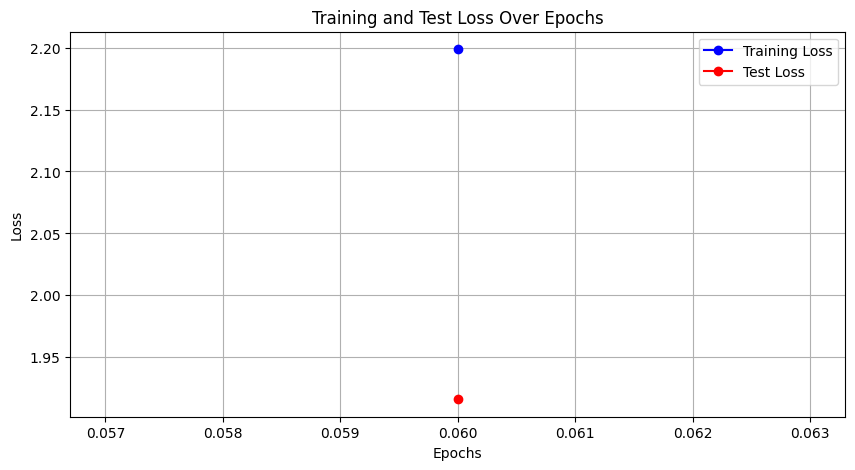

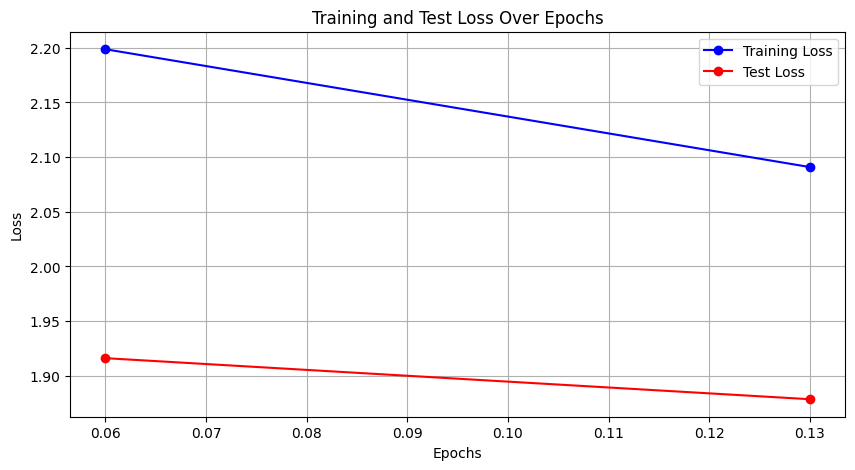

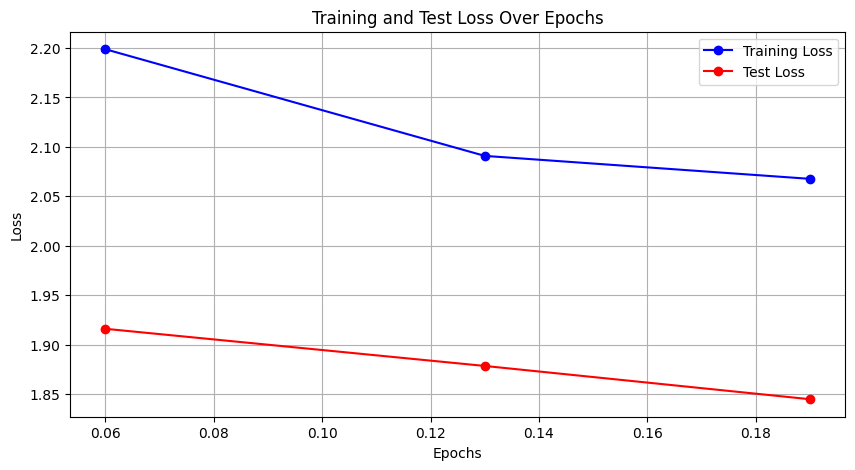

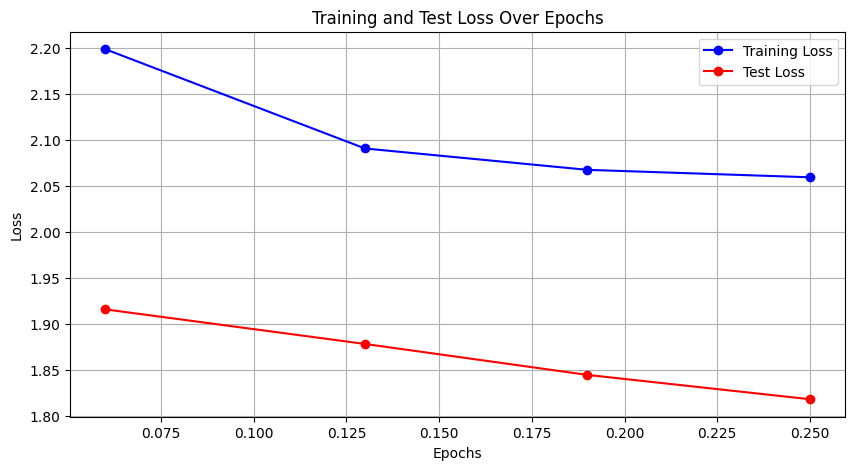

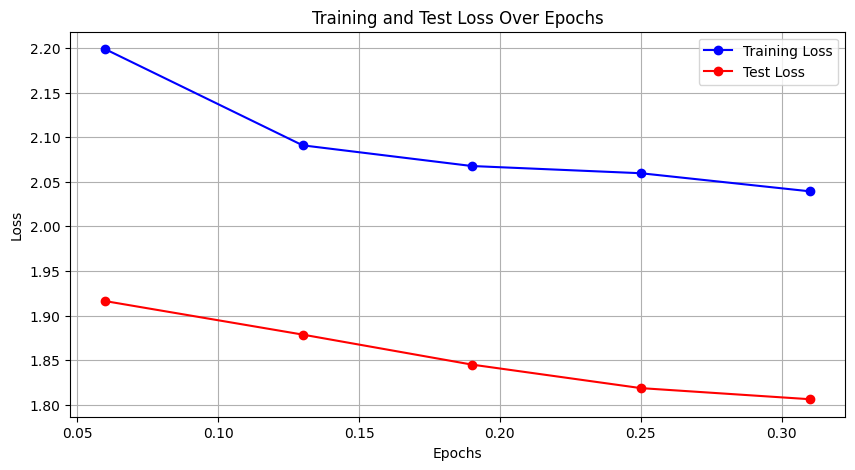

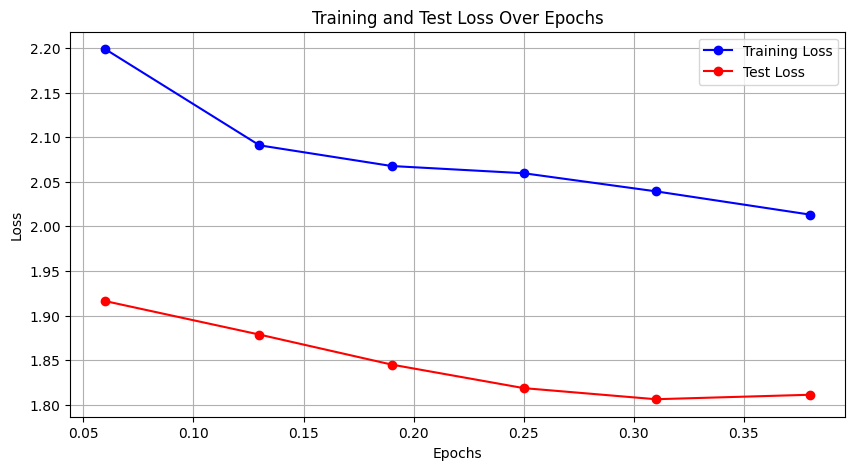

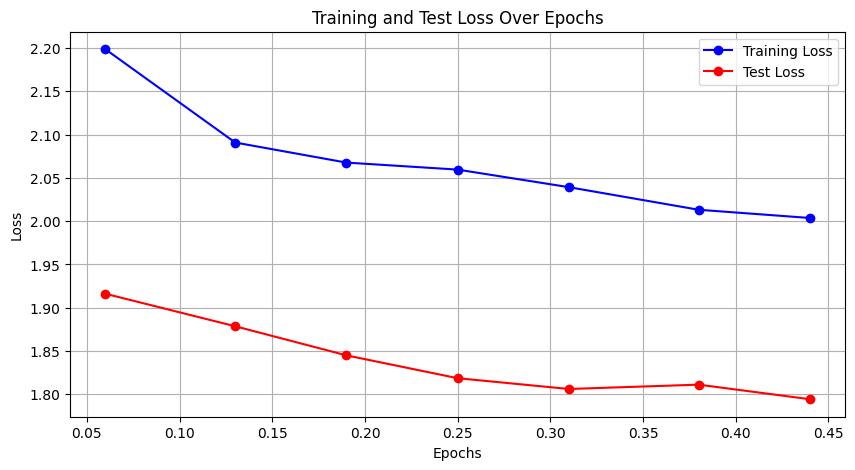

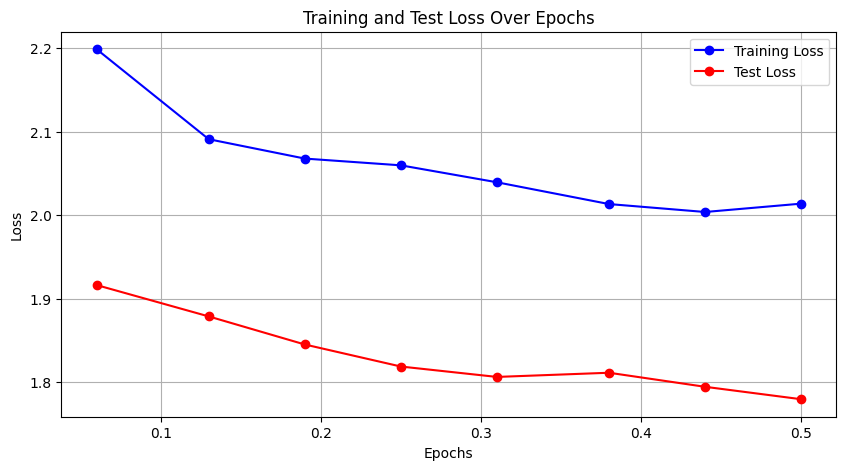

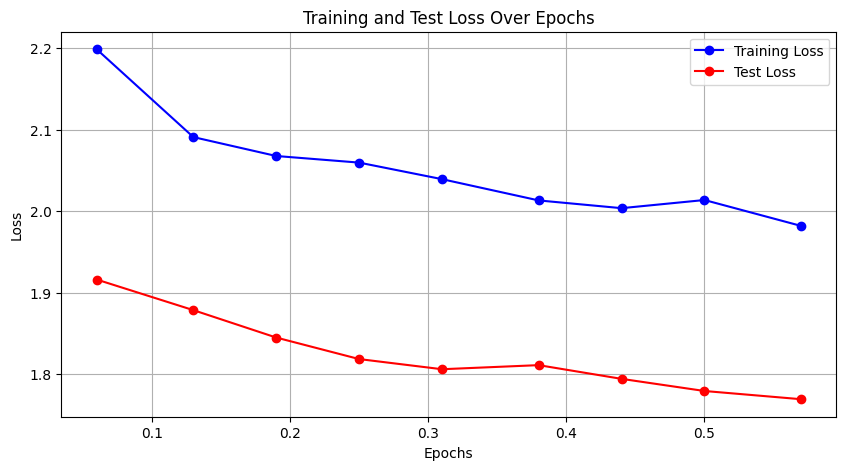

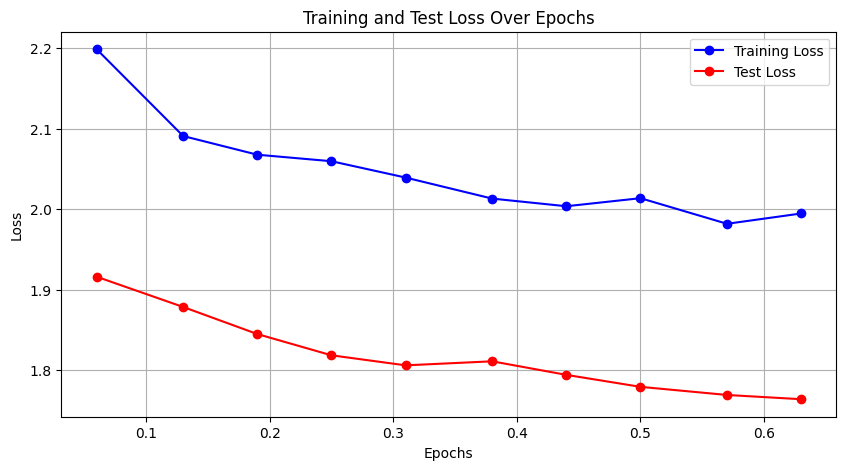

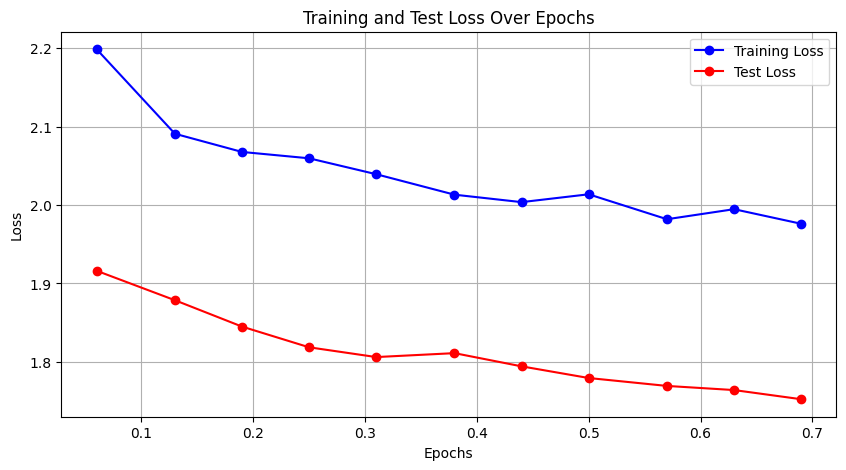

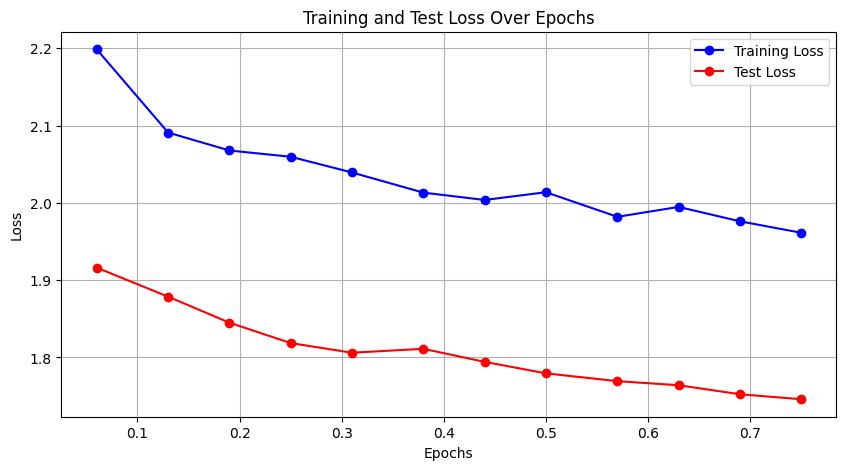

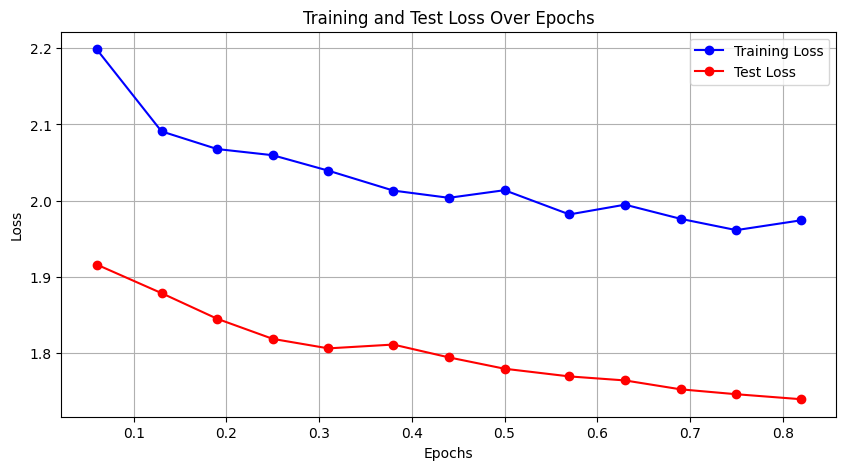

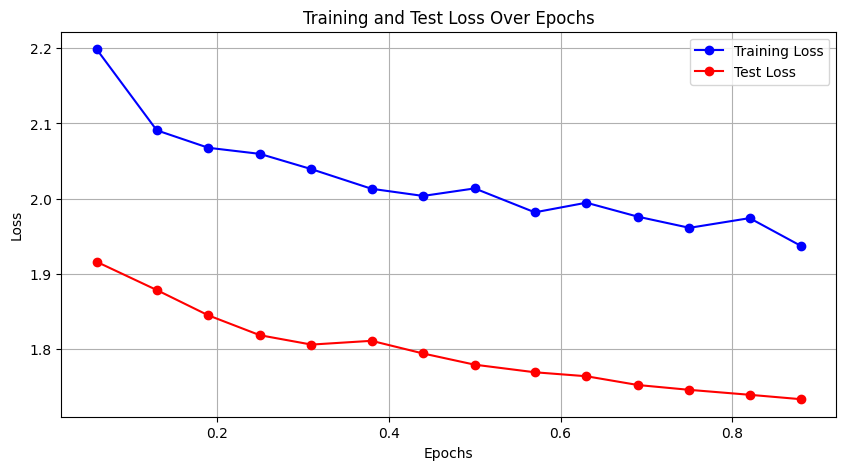

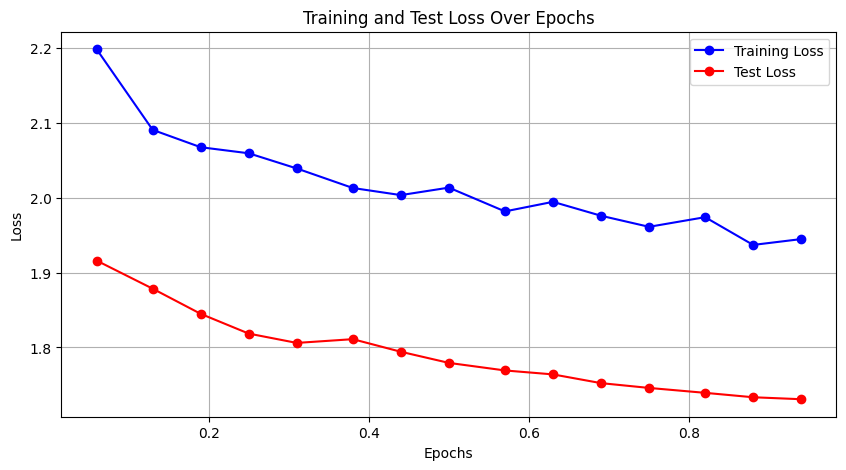

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model,
    arguments,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=None,
    callbacks=[LossLoggingCallback()]
)

trainer.train()

# Evaluate FN model

In [ ]:
input_file_path = f"/kaggle/input/23-dec-wiktionary/cleaned_splits/test.jsonl"
output_file_path = f"preds_fn.jsonl"

data = load_dataset_for_inference(input_file_path, "input_text", limit=300)

run_inference_over_dataset(model, tokenizer, data, "input_text", output_file_path)

  0%|          | 0/38 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 38/38 [01:48<00:00,  2.85s/it]


In [ ]:
scores = evaluate_model_with_validation_dataset("preds_fn.jsonl", "target_text",
                                                "generated_text")

print(scores)

{'bleu': 8.217074942324118, 'rougeL': 0.3424981381375902, 'bert-f1': 0.7675328489144643}


DEBUG result: {'bleu': 2.868285950028768, 'rougeL': 0.272921024573759, 'bert-f1': 0.7403375256061554}

In [ ]:
some_inputs = ["""<LM> Контекст: \"У Плутона есть спутник Харон, который по диаметру,
что само по себе странно, лишь вдвое меньше своего небесного сюзерена.\" Определение слова \"спутник\": """,
              """<LM> Контекст: \"Уже совсем близко от площади после очень сильного порыва
              ветра мой спутник вдруг снял с себя кепку и бросил её по ветру.\" Определение слова \"спутник\": """,
              """<LM> Контекст: \"Возглавляемая им группа инженеров предлагает выводить спутник
              на орбиту многоступенчатой ракетой с параллельным расположением ступеней.\" Определение слова \"спутник\": """]
preds = run_inference(model, tokenizer, some_inputs)
print(preds)

['небольшой небесный объект, движущийся по орбите вокруг какого-либо небесного тела', 'тот, кто идёт рядом с кем-либо, сопровождает кого-либо', 'космический аппарат, предназначенный для вывода на околоземную орбиту']


DEBUG result: ['небольшой небесный объект, вращающийся вокруг планеты', 'сопровождающий кого-либо', 'космический аппарат, предназначенный для выведения на орбиту Земли']

# Conclusion

As you can see, I successfully fine-tuned the model for the task of definition modeling.

The initial metrics of {'bleu': 0.8564100536381719, 'rougeL': 0.10269194577784987, 'bert-f1': 0.649014317591985}
are now {'bleu': 8.217074942324118, 'rougeL': 0.3424981381375902, 'bert-f1': 0.7675328489144643}.

The examples of the model usage above show that the geenrated definitions are correct and coherent.

The drawback of this work is that the model should have been trained longer, but I don't have time and I still need my Kaggle GPU time.

The model can be later used in NLP tasks, such as semantic change detection.

I will provide below a visualization of such usage from my diploma:
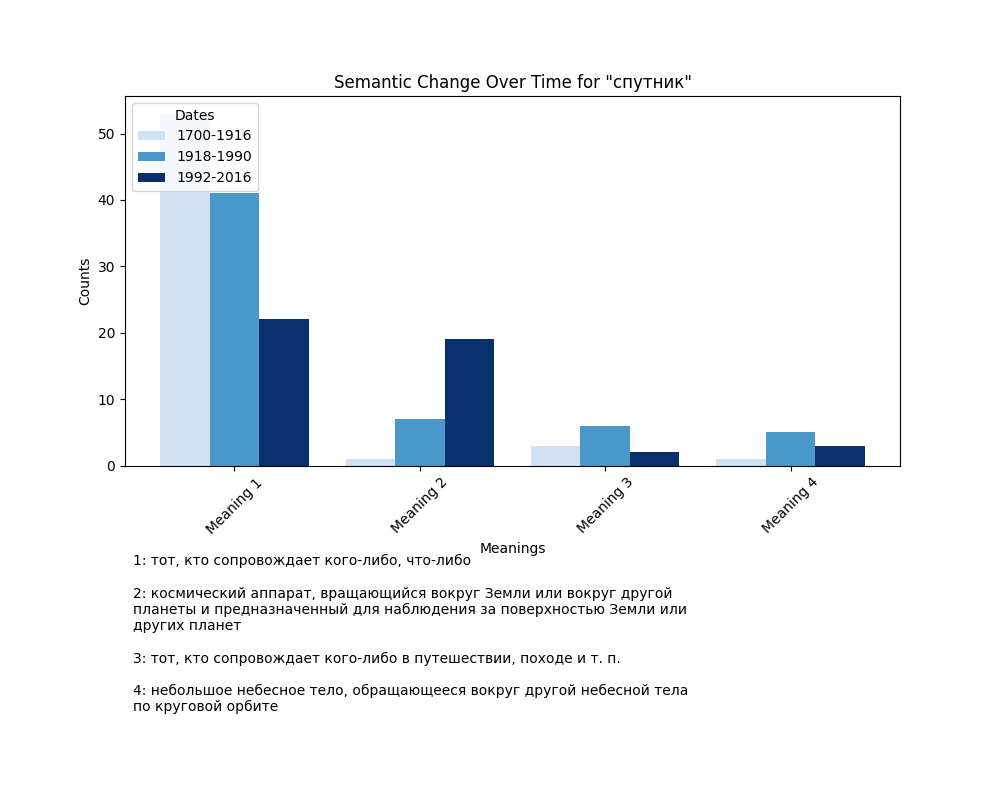